# CITS5017 Project 1
Kaylee Molin (22734429)

September 2023

---

### Importing Relevant Packages

In [46]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical # FIX ask if this is allowed
from sklearn.model_selection import GridSearchCV
# from scikeras.wrappers import KerasClassifier # for hyperparam tuning only
from tensorflow.keras.optimizers import SGD
import os, time
from sklearn.metrics import f1_score,classification_report,confusion_matrix,ConfusionMatrixDisplay



### Loading dataset

In [47]:
# Loading the CIFAR-10 dataset and ensuring its dimensions match expectations

(X_train_original, y_train_original), (X_test_original, y_test_original) = tf.keras.datasets.cifar10.load_data()

# Asserting that the loaded dataset has the correct dimensions
assert X_train_original.shape == (50000, 32, 32, 3)  # Training images should be 50,000 samples of 32x32 pixels in RGB.
assert X_test_original.shape == (10000, 32, 32, 3)   # Test images should be 10,000 samples of 32x32 pixels in RGB.
assert y_train_original.shape == (50000, 1)          # Training labels should have a shape of (50000, 1).
assert y_test_original.shape == (10000, 1)           # Test labels should have a shape of (10000, 1).

### Normalising the pixel values to be between 0 and 1
These models perform better when data is in this range.

In [48]:
# Normalising the pixel values of training and test data by scaling them to the range [0, 1].
X_train_norm, X_test = X_train_original/255.0, X_test_original/255.0
y_test=y_test_original
y_train = y_train_original

### (i) Forming a validation set from the training set

To create a validation set, we are using an 85/15 ratio, dividing the current training data into a reduced training set and a separate validation set. The original testing set remains unchanged.

In [49]:
X_train, X_val, y_train, y_val = train_test_split(X_train_norm, y_train, test_size=0.15, random_state=22, stratify=y_train_original)

# Print the shapes of the resulting datasets
print("Training set shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("\nValidation set shapes:")
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)
print("\nTest set shapes:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Training set shapes:
X_train: (42500, 32, 32, 3)
y_train: (42500, 1)

Validation set shapes:
X_val: (7500, 32, 32, 3)
y_val: (7500, 1)

Test set shapes:
X_test: (10000, 32, 32, 3)
y_test: (10000, 1)


> The dimensions of each set is displayed above. The 'y' data contains the corresponding labels for each instance in the dataset.

### (ii) Function to display 20 randomly sampled images

In [50]:
def display_random_subset(X, y, class_names, title):
    '''
    Display a random subset of images with their corresponding class labels.

    Parameters:
        X (numpy.ndarray):  The input images.
        y (numpy.ndarray):  The corresponding class labels.
        class_names (list): A list of class names.
        title (str):        The title for the figure.

    '''
    plt.figure(figsize=(12, 6))
    indices = np.random.randint(0, len(X), size=20)
    
    for i, index in enumerate(indices):
        plt.subplot(4, 5, i+1)
        plt.imshow(X[index])
        plt.title(class_names[y[index][0]])
        plt.axis('off')
    
    plt.suptitle(title, fontsize=16)  # Adding a title to the entire figure
    plt.subplots_adjust(wspace=0.2, hspace=0.4)  # Adjusting the horizontal and vertical space
    #plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjusting layout for the title
    plt.show()


In [51]:
# Load class names from TFDS
dataset_info = tfds.builder("cifar10")
class_names = dataset_info.info.features["label"].names

### Displaying 20 random images from the training set

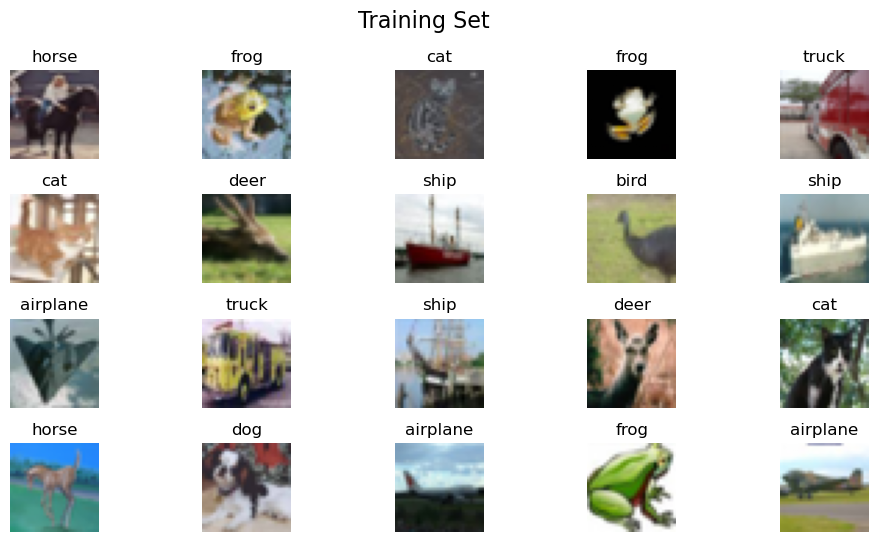

In [52]:
display_random_subset(X_train, y_train, class_names, "Training Set")

### Displaying 20 random images from the validation set

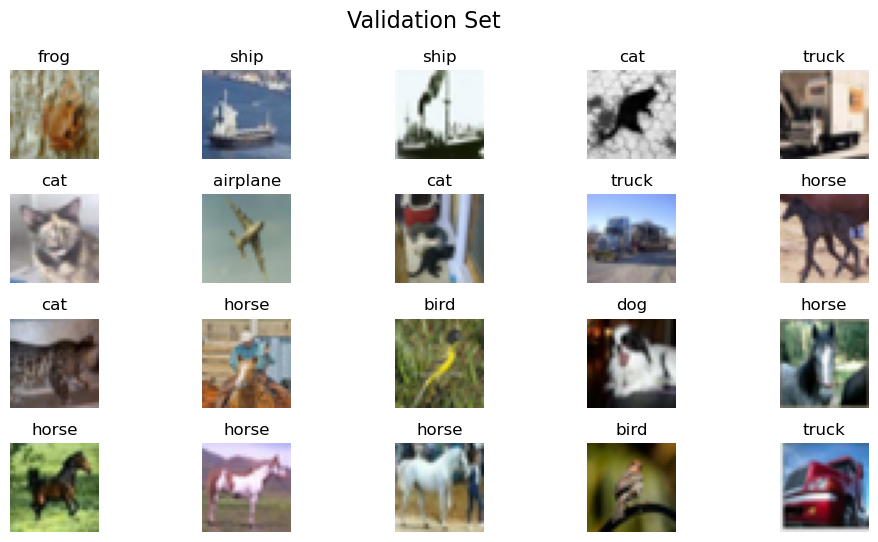

In [53]:
display_random_subset(X_val, y_val, class_names, "Validation Set")

### Displaying 20 random images from the testing set

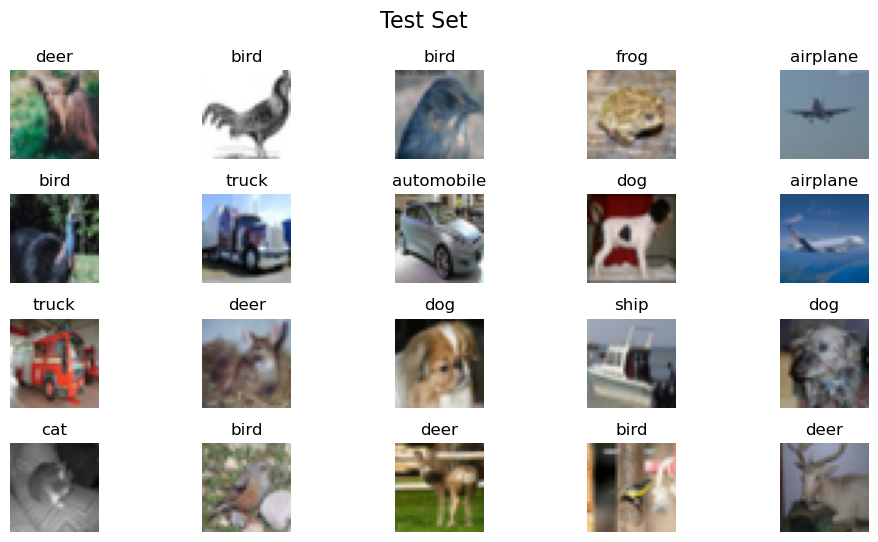

In [54]:
display_random_subset(X_test, y_test, class_names, "Test Set")

In [10]:
# ds, ds_info = tfds.load('cifar10', split='train', with_info=True)
# fig = tfds.show_examples(ds, ds_info)

In [11]:
# Get the number of classes
num_classes = len(class_names)

# y_train = to_categorical(y_train, num_classes)
# y_val = to_categorical(y_val, num_classes)
# y_test = to_categorical(y_test, num_classes)

In [12]:
# X_train.shape,X_test.shape,y_train.shape,y_test.shape


((42500, 32, 32, 3), (10000, 32, 32, 3), (42500, 1), (10000, 1))

### (iii) Training an MLP

In [13]:
def create_mlp_model(learning_rate=0.01, weight_initializer='glorot_uniform', dropout_rate=0):
    '''
    Create an MLP model with customisable hyperparameters.

    Parameters:
        learning_rate (float):      The learning rate for the optimizer.
        weight_initializer (str):   The weight initialisation method for layers.
        dropout_rate (float):       The dropout rate for dropout layers.

    Returns:
        keras.models.Sequential: An MLP model.
    '''
    model = Sequential([
        Flatten(input_shape=[32, 32, 3]),
        Dense(512, activation='relu', kernel_initializer=weight_initializer),
        Dropout(dropout_rate),
        Dense(256, activation='relu', kernel_initializer=weight_initializer),
        Dropout(dropout_rate),
        Dense(10, activation='softmax')
    ])

    optimizer = SGD(learning_rate=learning_rate)
    # optimizer=tf.keras.optimizers.legacy.Adam()

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

> The above code defines the architecture of the MLP model. This MLP consists of an input layer, two hidden layers, and an output layer.

**Architecture**

>*Input layer*: 
- The inputted images have dimensions (32, 32, 3). When flattened, the resulting array is 3072 long.

>*Hidden layers*: 
- This model uses two hidden layers, one with 512 neurons and the other with 256 neurons and has been chosen purposefully. Firstly, it reduces model complexity, which can prevent overfitting to the training data. Secondly, it accelerates training as fewer parameters need tuning. This configuration of neurons in the hidden layers aligns with common choices in various neural network architectures. 
- The input layer begins with 3072 neurons, and a gradual reduction in the number of neurons in each layer results in an efficient and effective model. 
- I did also try using more neurons and 3 hidden layers, however, the increase in accuracy was minimal. Hence, I opted for a simpler model with comparable accuracy. 
- I opted for the $ReLU$ (Rectified Linear Unit) activation function, which transforms inputs into values greater than or equal to zero. $ReLU$ is quick and effective in addressing the vanishing gradient problem that can arise with other activation functions.

>*Output layer*: 
- The output layer consists of 10 neurons, corresponding to the 10 possible classes in the dataset. 
- The activation function used in this layer is softmax. Softmax is chosen here because it is well-suited for multi-class classification problems, providing probability-like outputs that represent the likelihood of an input belonging to each class.

>*Optimisation*:
- Stochastic Gradient Descent (SGD) was chosen for this model. SGD iteratively updates the model's parameters based on the gradient of the loss function with respect to those parameters.
- Its adaptability and broad applications make it a suitable choice for optimising the MLP's weights and biases in this model.

### Exploring Hyperparameter Settings
> The following code aims to find the best hyperparameter combination for maximising the accuracy using the above model. It has been commented out as training has already been completed. It iterates through different hyperparameter combinations, training a model for each, and outputting the accuracy and loss.

In this experimentation, I focused on three hyperparameters: `weight_initializations`, `dropout_rates` and `learning_rates`.

1. Weight Initialisations
    - I chose to experiment with two common techniques: `glorot_uniform` and `he_normal`
    - `glorot_uniform` (also known as Xavier initialization) aims to keep the variance of activations roughly consistent across layers. `he_normal` (He initialization) is particularly suitable for deep networks and can handle the vanishing gradient problem well.
    - He initialisation aligns well with ReLU and its variants, while Glorot initialisation suits other functions, including Softmax, making it relevant here.

2. Dropout Rates
    - Dropout is a regularisation technique that aids in preventing overfitting. I tested two dropout rates: 0 and 0.2.
    - A rate of 0 represents no dropout, while 0.2 means that 20% of neurons were dropped out during training. 0.2 is used as the default dropout value.

3. Learning Rates
    - Learning rate controls the step size during training. I experimented with two values: 0.01 and 0.
    - A lower learning rate (0.01) tends to result in slower but more stable convergence, while a higher rate (0.1) can lead to faster but potentially less stable learning. The goal was to find a balance that achieves optimal training performance.



In [14]:
weight_initializations = ['glorot_uniform', 'he_normal']
dropout_rates = [0, 0.2]
learning_rates = [0.01, 0.1]

# Lists to store results
results = []

for weight_init in weight_initializations:
    for dropout_rate in dropout_rates:
        for learning_rate in learning_rates:
            model = create_mlp_model(learning_rate=learning_rate, weight_initializer=weight_init, dropout_rate=dropout_rate)

            # Define early stopping callback
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

            # Train the model with early stopping on the validation set
            history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

            # Evaluate the model on the test set
            test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

            # Print results for each combination of hyperparameters
            print(f"Weight Init: {weight_init}, Dropout Rate: {dropout_rate}, Learning Rate: {learning_rate}")
            print("Test loss:", test_loss)
            print("Test accuracy:", test_accuracy)
            print("-" * 40)

            # Store results
            results.append({
                'Weight Init': weight_init,
                'Learning Rate': learning_rate,
                'Dropout Rate': dropout_rate,
                'Test Accuracy': test_accuracy
            })

# Print results
for result in results:
    print("Weight Init:", result['Weight Init'])
    print("Learning Rate:", result['Learning Rate'])
    print("Dropout Rate:", result['Dropout Rate'])
    print("Test Accuracy:", result['Test Accuracy'])


2023-09-03 22:08:17.706588: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-09-03 22:08:17.706611: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-09-03 22:08:17.706618: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-09-03 22:08:17.706654: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-03 22:08:17.706675: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100
   1/1329 [..............................] - ETA: 7:56 - loss: 2.7717 - accuracy: 0.0938

2023-09-03 22:08:18.769106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - ETA: 0s - loss: 1.9748 - accuracy: 0.2912

2023-09-03 22:08:28.515994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - 11s 8ms/step - loss: 1.9748 - accuracy: 0.2912 - val_loss: 3.2187 - val_accuracy: 0.1291
Epoch 2/100
1329/1329 [==============================] - 10s 8ms/step - loss: 1.8816 - accuracy: 0.3338 - val_loss: 2.1530 - val_accuracy: 0.2637
Epoch 3/100
1329/1329 [==============================] - 10s 8ms/step - loss: 2.0479 - accuracy: 0.3064 - val_loss: 3.4313 - val_accuracy: 0.1651
Epoch 4/100
1329/1329 [==============================] - 10s 8ms/step - loss: 2.7336 - accuracy: 0.2629 - val_loss: 7.1242 - val_accuracy: 0.1821
Epoch 5/100
1329/1329 [==============================] - 10s 8ms/step - loss: 3.6169 - accuracy: 0.2486 - val_loss: 9.9480 - val_accuracy: 0.1669
Epoch 6/100
1329/1329 [==============================] - 10s 8ms/step - loss: 4.6423 - accuracy: 0.2320 - val_loss: 17.6675 - val_accuracy: 0.1552
Epoch 7/100
1329/1329 [==============================] - 10s 8ms/step - loss: 5.9765 - accuracy: 0.2260 - val_loss: 10.4146 - val_accur

Weight Init: glorot_uniform, Dropout Rate: 0, Learning Rate: 0.01
Test loss: 2.1505348682403564
Test accuracy: 0.25929999351501465
----------------------------------------
Epoch 1/100
   8/1329 [..............................] - ETA: 10s - loss: 821676480.0000 - accuracy: 0.0781

2023-09-03 22:10:27.878065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0999

2023-09-03 22:10:37.579155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - 11s 8ms/step - loss: nan - accuracy: 0.0999 - val_loss: nan - val_accuracy: 0.1000
Epoch 2/100
1329/1329 [==============================] - 10s 8ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 3/100
1329/1329 [==============================] - 10s 8ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 4/100
1329/1329 [==============================] - 10s 8ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 5/100
1329/1329 [==============================] - 10s 8ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 6/100
1329/1329 [==============================] - 10s 8ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 7/100
1329/1329 [==============================] - 10s 8ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 8/100
1329/1329 [=========

Epoch 1/100
   1/1329 [..............................] - ETA: 7:26 - loss: 3.0869 - accuracy: 0.2188

2023-09-03 22:12:14.221310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - ETA: 0s - loss: 2.0693 - accuracy: 0.2618

2023-09-03 22:12:25.833546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - 13s 9ms/step - loss: 2.0693 - accuracy: 0.2618 - val_loss: 1.9144 - val_accuracy: 0.3289
Epoch 2/100
1329/1329 [==============================] - 12s 9ms/step - loss: 1.9328 - accuracy: 0.3149 - val_loss: 2.4924 - val_accuracy: 0.1851
Epoch 3/100
1329/1329 [==============================] - 12s 9ms/step - loss: 1.9383 - accuracy: 0.3200 - val_loss: 2.0338 - val_accuracy: 0.3117
Epoch 4/100
1329/1329 [==============================] - 12s 9ms/step - loss: 2.0974 - accuracy: 0.2953 - val_loss: 4.2716 - val_accuracy: 0.1933
Epoch 5/100
1329/1329 [==============================] - 13s 10ms/step - loss: 2.5346 - accuracy: 0.2618 - val_loss: 4.2323 - val_accuracy: 0.1789
Epoch 6/100
1329/1329 [==============================] - 12s 9ms/step - loss: 3.0966 - accuracy: 0.2476 - val_loss: 8.5035 - val_accuracy: 0.1408
Epoch 7/100
1329/1329 [==============================] - 13s 10ms/step - loss: 3.7498 - accuracy: 0.2366 - val_loss: 10.1008 - val_accu

Epoch 1/100


2023-09-03 22:14:38.597063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - ETA: 0s - loss: nan - accuracy: 0.1000

2023-09-03 22:14:50.164293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - 13s 9ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 2/100
1329/1329 [==============================] - 12s 9ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 3/100
1329/1329 [==============================] - 12s 9ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 4/100
1329/1329 [==============================] - 14s 11ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 5/100
1329/1329 [==============================] - 12s 9ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 6/100
1329/1329 [==============================] - 11s 8ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 7/100
1329/1329 [==============================] - 12s 9ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 8/100
1329/1329 [========

Epoch 1/100
   7/1329 [..............................] - ETA: 11s - loss: 2.9234 - accuracy: 0.1205 

2023-09-03 22:16:44.757921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - ETA: 0s - loss: 1.9852 - accuracy: 0.2898

2023-09-03 22:16:54.547689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - 11s 8ms/step - loss: 1.9852 - accuracy: 0.2898 - val_loss: 2.2268 - val_accuracy: 0.2460
Epoch 2/100
1329/1329 [==============================] - 10s 8ms/step - loss: 1.9242 - accuracy: 0.3218 - val_loss: 2.9183 - val_accuracy: 0.2112
Epoch 3/100
1329/1329 [==============================] - 11s 8ms/step - loss: 2.2827 - accuracy: 0.2867 - val_loss: 3.8819 - val_accuracy: 0.2163
Epoch 4/100
1329/1329 [==============================] - 10s 8ms/step - loss: 3.2526 - accuracy: 0.2446 - val_loss: 9.7022 - val_accuracy: 0.1491
Epoch 5/100
1329/1329 [==============================] - 10s 8ms/step - loss: 4.3078 - accuracy: 0.2310 - val_loss: 14.7420 - val_accuracy: 0.1607
Epoch 6/100
1329/1329 [==============================] - 11s 8ms/step - loss: 5.7697 - accuracy: 0.2273 - val_loss: 15.1138 - val_accuracy: 0.1308
Epoch 7/100
1329/1329 [==============================] - 12s 9ms/step - loss: 7.3406 - accuracy: 0.2231 - val_loss: 19.5281 - val_accu

Weight Init: he_normal, Dropout Rate: 0, Learning Rate: 0.01
Test loss: 2.233855724334717
Test accuracy: 0.24549999833106995
----------------------------------------


Epoch 1/100
   1/1329 [..............................] - ETA: 8:23 - loss: 2.9806 - accuracy: 0.0312

2023-09-03 22:18:46.902810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - ETA: 0s - loss: nan - accuracy: 0.1000

2023-09-03 22:18:57.547061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - 12s 9ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 2/100
1329/1329 [==============================] - 13s 10ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 3/100
1329/1329 [==============================] - 11s 8ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 4/100
1329/1329 [==============================] - 10s 8ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 5/100
1329/1329 [==============================] - 10s 8ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 6/100
1329/1329 [==============================] - 10s 7ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 7/100
1329/1329 [==============================] - 10s 7ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 8/100
1329/1329 [========

Weight Init: he_normal, Dropout Rate: 0, Learning Rate: 0.1
Test loss: nan
Test accuracy: 0.10000000149011612
----------------------------------------
Epoch 1/100
   1/1329 [..............................] - ETA: 7:18 - loss: 3.2452 - accuracy: 0.1562

2023-09-03 22:20:39.213696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - ETA: 0s - loss: 2.1249 - accuracy: 0.2612

2023-09-03 22:20:50.624859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - 13s 9ms/step - loss: 2.1249 - accuracy: 0.2612 - val_loss: 2.5656 - val_accuracy: 0.2088
Epoch 2/100
1329/1329 [==============================] - 12s 9ms/step - loss: 1.9632 - accuracy: 0.3070 - val_loss: 2.7195 - val_accuracy: 0.1767
Epoch 3/100
1329/1329 [==============================] - 12s 9ms/step - loss: 1.9391 - accuracy: 0.3160 - val_loss: 2.3595 - val_accuracy: 0.2252
Epoch 4/100
1329/1329 [==============================] - 11s 9ms/step - loss: 1.9620 - accuracy: 0.3158 - val_loss: 2.7822 - val_accuracy: 0.1900
Epoch 5/100
1329/1329 [==============================] - 12s 9ms/step - loss: 2.1283 - accuracy: 0.2900 - val_loss: 3.6660 - val_accuracy: 0.2141
Epoch 6/100
1329/1329 [==============================] - 12s 9ms/step - loss: 2.4610 - accuracy: 0.2667 - val_loss: 4.1071 - val_accuracy: 0.1975
Epoch 7/100
1329/1329 [==============================] - 12s 9ms/step - loss: 2.9808 - accuracy: 0.2510 - val_loss: 4.0342 - val_accurac

Weight Init: he_normal, Dropout Rate: 0.2, Learning Rate: 0.01
Test loss: 2.3864293098449707
Test accuracy: 0.21940000355243683
----------------------------------------
Epoch 1/100
   1/1329 [..............................] - ETA: 7:33 - loss: 3.0339 - accuracy: 0.1875

2023-09-03 22:23:13.508770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0999

2023-09-03 22:23:24.565290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - 12s 9ms/step - loss: nan - accuracy: 0.0999 - val_loss: nan - val_accuracy: 0.1000
Epoch 2/100
1329/1329 [==============================] - 12s 9ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 3/100
1329/1329 [==============================] - 12s 9ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 4/100
1329/1329 [==============================] - 12s 9ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 5/100
1329/1329 [==============================] - 11s 9ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 6/100
1329/1329 [==============================] - 12s 9ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 7/100
1329/1329 [==============================] - 11s 9ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 8/100
1329/1329 [=========

> The combination of hyperameters that resulted int he highest accuracy are:

Weight Init: glorot_uniform
Dropout Rate: 0.2
Learning Rate: 0.01
Using the SGD optimiser.

The resulting validation accuracy is: 0.527
THe resulting validation loss is: 1.324

In [28]:
model_filename = 'Molin_Kaylee-MLP'

try:
    # Try to load the model
    model_mlp = tf.keras.models.load_model(model_filename)
    print("Model already exists.")
    model_mlp.summary()
    history_mlp = model_mlp.fit(X_train, y_train, epochs = 1, validation_data = (X_val, y_val), callbacks = [early_stopping])

except OSError:
    # Model file does not exist, create and train a new model
    print("Cannot find an existing MLP model in the current directory. Creating and training a new model.")
    model_mlp = create_mlp_model(learning_rate=0.01, weight_initializer='glorot_uniform', dropout_rate=0.2)
    model_mlp.summary()
    
    mlp_start = time.time()
    history_mlp = model_mlp.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])
    mlp_end = time.time()
    
    # Save the trained model
    model_mlp.save(model_filename)

Model already exists.
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 3072)              0         
                                                                 
 dense_24 (Dense)            (None, 512)               1573376   
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 dense_25 (Dense)            (None, 256)               131328    
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 dense_26 (Dense)            (None, 10)                2570      
                                                                 
Total params: 1707274 (6.51 MB)


In [33]:
model_mlp.evaluate(X_test, y_test)


313/313 [==============================] - 2s 5ms/step - loss: 10.0287 - accuracy: 0.2501


[10.028675079345703, 0.2500999867916107]

In [38]:
# THIS IS COPY AND PASTED FIX
# i changed it a bit, may need ot change more

mlp_pred = np.argmax(model_mlp.predict(X_test),axis=-1)
mlp_eval = model_mlp.evaluate(X_test,y_test,verbose=0)
print(f"MLP Model Accuracy: {mlp_eval[1]:.4f}, Loss: {mlp_eval[0]:.4f}\n")
print(f"MLP Average F1 Score: {f1_score(y_test, mlp_pred, average='macro'):.4f}\n")
print(f"MLP F1 Scores for Different Classes:\n{classification_report(y_test, mlp_pred, target_names=class_names)}")

313/313 [==============================] - 1s 4ms/step
MLP Model Accuracy: 0.2501, Loss: 10.0287

MLP Average F1 Score: 0.2182

MLP F1 Scores for Different Classes:
              precision    recall  f1-score   support

    airplane       0.21      0.27      0.24      1000
  automobile       0.83      0.01      0.01      1000
        bird       0.17      0.48      0.25      1000
         cat       0.36      0.02      0.04      1000
        deer       0.25      0.16      0.19      1000
         dog       0.19      0.44      0.26      1000
        frog       0.41      0.44      0.43      1000
       horse       0.59      0.14      0.22      1000
        ship       0.35      0.46      0.40      1000
       truck       0.59      0.08      0.14      1000

    accuracy                           0.25     10000
   macro avg       0.40      0.25      0.22     10000
weighted avg       0.40      0.25      0.22     10000



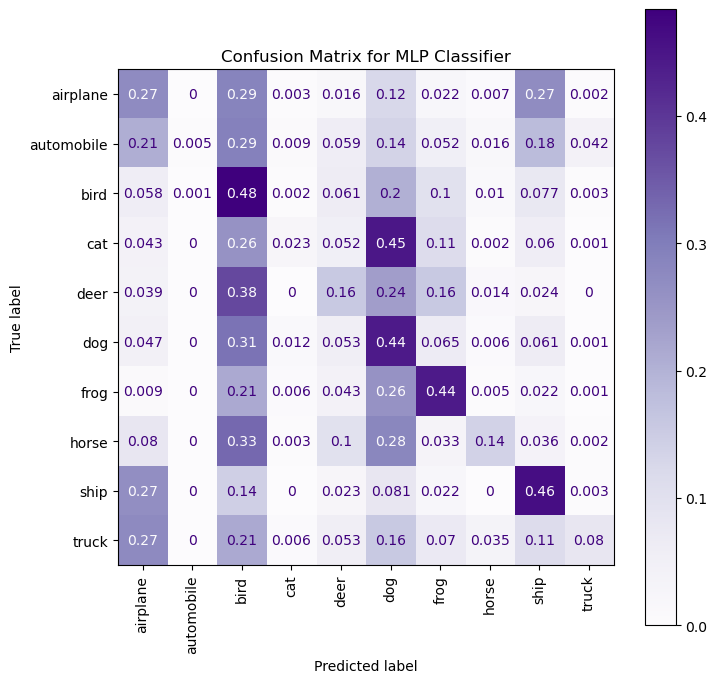

In [41]:
def plot_confusion_matrix(y_test, y_pred, display_labels=class_names, cmap=plt.cm.Purples, title="Confusion Matrix"):
    fig, ax = plt.subplots(1, figsize=(8, 8))
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    
    conf_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    conf_display.plot(cmap=cmap, ax=ax, xticks_rotation=90)
    
    # Set the title
    ax.set_title("Confusion Matrix for MLP Classifier")

# Plot Confusion Matrix with a title
plot_confusion_matrix(y_test, mlp_pred, title="MLP Confusion Matrix")
plt.show()


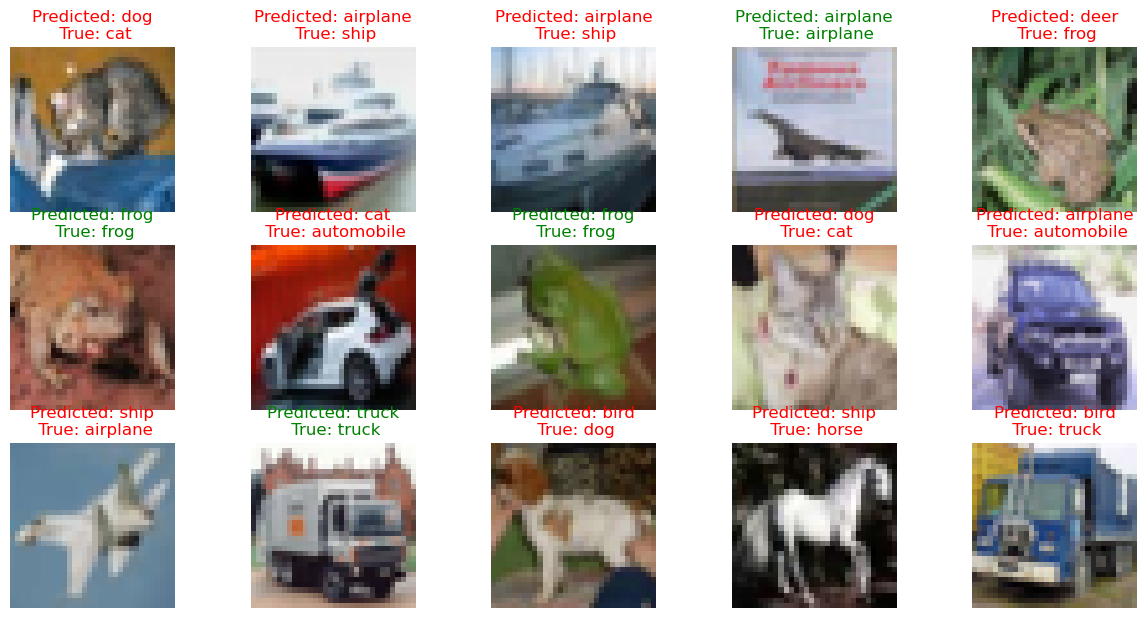

In [43]:
# copy pasted FIX
def predict_sample_images(images, true_labels, pred_labels, rows, cols, class_names):
    num = rows * cols  # Define the number of images to display
    plt.figure(figsize=(15, 15))
    for i in range(num):
        true_label_idx = int(true_labels[i])  # Convert to integer
        pred_label_idx = int(pred_labels[i])  # Convert to integer
        if pred_label_idx == true_label_idx:  # If prediction is correct
            ax = plt.subplot(2 * rows, cols, i + 1)
            plt.imshow(images[i])
            plt.axis('off')
            ax.set_title(f"Predicted: {class_names[pred_label_idx]}\n True: {class_names[true_label_idx]}", color='green')
        else:
            ax = plt.subplot(2 * rows, cols, i + 1)
            plt.imshow(images[i])
            plt.axis('off')
            ax.set_title(f"Predicted: {class_names[pred_label_idx]}\n True: {class_names[true_label_idx]}", color='red')
    plt.show()
    return

# MLP predict sample images
predict_sample_images(X_test, y_test, mlp_y_pred, 3, 5, class_names)


In [ ]:
# # Get the number of classes
# # num_classes = len(class_names)

# # Create the MLP model
# model_mlp = tf.keras.Sequential([
#     tf.keras.layers.Flatten(input_shape=[32, 32, 3]),
#     #tf.keras.layers.Dense(1024, activation='relu'),  
#     tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal'),
#     Dropout(0.2),  # Use the dropout_rate parameter here
#     # tf.keras.layers.Dense(1000, activation='relu'),   
#     tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal'),
#     Dropout(0.2),  # Use the dropout_rate parameter here
#     tf.keras.layers.Dense(num_classes, activation='softmax')  # Output layer with num_classes units and softmax activation
# ])

# optimizer=tf.keras.optimizers.legacy.Adam()
# #optimizer = SGD(learning_rate=0.1)

# # Compile the model
# model_mlp.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Defining the early stopping callback
# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# history = model_mlp.fit(X_train, y_train, epochs=100,batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

# model_mlp.summary()


### https://github.com/adameksopot/MLP-for-Cifar10-/blob/master/MLP.ipynb
### try this! very good accuracy

In [ ]:
# # Hyperparameters to experiment with
# weight_initializations = ['glorot_uniform', 'he_normal'] # read https://keras.io/api/layers/initializers/ for more initialisers
# dropout_rates = [0.2, 0.4]
# input_shape=(32, 32, 3)

# for weight_init in weight_initializations:
#     for dropout_rate in dropout_rates:

#         print("Weight initialisation: {}".format(weight_init))
#         print("Dropout rate: {}".format(dropout_rate))
#         # Create the MLP model with hyperparameters
#         model = Sequential([
#             Flatten(input_shape=input_shape),
#             Dense(512, activation='relu', kernel_initializer=weight_init),
#             Dropout(dropout_rate),
#             Dense(256, activation='relu', kernel_initializer=weight_init),
#             Dropout(dropout_rate),
#             Dense(num_classes, activation='softmax')
#         ])

#         # Compile the model
#         model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#                         loss='sparse_categorical_crossentropy',
#                         metrics=['accuracy'])

#         # Define early stopping callback
#         early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#         # Train the model with early stopping on the validation set
#         history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

#         # Evaluate the model on the test set
#         test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
        
#         # Print results for each combination of hyperparameters
#         print(f"Weight Init: {weight_init}, Dropout Rate: {dropout_rate}")
#         print("Test accuracy:", test_accuracy)
#         print("-" * 40)

## CNN

In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization

num_classes = 10
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 64
epochs = 10
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_val, y_val, verbose=2)
print("\nTest accuracy:", test_accuracy)


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 15, 15, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                     

2023-09-04 12:20:39.815922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


665/665 [==============================] - ETA: 0s - loss: 1.4427 - accuracy: 0.4853

2023-09-04 12:20:54.878668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


665/665 [==============================] - 17s 23ms/step - loss: 1.4427 - accuracy: 0.4853 - val_loss: 1.4871 - val_accuracy: 0.4779
Epoch 2/10
665/665 [==============================] - 13s 20ms/step - loss: 1.1996 - accuracy: 0.5782 - val_loss: 2.5603 - val_accuracy: 0.3688
Epoch 3/10
665/665 [==============================] - 13s 20ms/step - loss: 1.1698 - accuracy: 0.5926 - val_loss: 1.8462 - val_accuracy: 0.4556
Epoch 4/10
665/665 [==============================] - 16s 24ms/step - loss: 1.1578 - accuracy: 0.6025 - val_loss: 2.2120 - val_accuracy: 0.4021
Epoch 5/10
665/665 [==============================] - 15s 22ms/step - loss: 1.2160 - accuracy: 0.5906 - val_loss: 2.5967 - val_accuracy: 0.3779
Epoch 6/10
665/665 [==============================] - 13s 20ms/step - loss: 1.2335 - accuracy: 0.5897 - val_loss: 1.7521 - val_accuracy: 0.4913
Epoch 7/10
665/665 [==============================] - 11s 17ms/step - loss: 1.3246 - accuracy: 0.5735 - val_loss: 2.0409 - val_accuracy: 0.4795
Epo

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization

num_classes = 10

# Define hyperparameter values to explore
kernel_sizes = [(3, 3), (5, 5)]
num_kernels = [32, 64]
activation_functions = ['relu', 'tanh']

# Lists to store results
results = []

# Iterate through all combinations
for kernel_size in kernel_sizes:
    for num_kernel in num_kernels:
        for activation_function in activation_functions:
            model = Sequential()
            model.add(Conv2D(num_kernel, kernel_size, activation=activation_function, input_shape=(32, 32, 3)))
            model.add(MaxPooling2D((2, 2)))
            model.add(BatchNormalization())
            model.add(Conv2D(num_kernel * 2, kernel_size, activation=activation_function))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(num_kernel * 4, kernel_size, activation=activation_function))
            model.add(MaxPooling2D((2, 2)))
            model.add(Flatten())
            model.add(Dense(128, activation=activation_function))
            model.add(BatchNormalization())
            model.add(Dense(64, activation=activation_function))
            model.add(Dense(num_classes, activation='softmax'))

            print("---")
            print("num_kernal: {}, activation_function: {}, kernel_size: {}".format(num_kernel, activation_function, kernel_size))

            # Compile the model
            model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

            # Train the model
            batch_size = 64
            epochs = 30
            history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=1)

            # Evaluate the model
            test_loss, test_accuracy = model.evaluate(X_val, y_val, verbose=0)

            # Store results
            results.append({
                'Kernel Size': kernel_size,
                'Number of Kernels': num_kernel,
                'Activation Function': activation_function,
                'Test Accuracy': test_accuracy
            })

# Print results
for result in results:
    print("Kernel Size:", result['Kernel Size'])
    print("Number of Kernels:", result['Number of Kernels'])
    print("Activation Function:", result['Activation Function'])
    print("Test Accuracy:", result['Test Accuracy'])
   
